In [7]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import matplotlib.pyplot as plt
import seaborn as sns
import os
if not os.path.exists('figures'):
    os.makedirs('figures')

sns.set_style('white')
sns.set_context('talk')
sns.set_palette('rainbow', n_colors=10)
!nvidia-smi

Wed Aug  7 11:59:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   51C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

I recommend a GPU for this part,  but it won't be necessary for future notebooks.

## Wigner

We begin with the most elementary ensemble in RMT: the wigner ensemble. This is a Hermitian matrix with random entries. It can be written as
$$ A = H + H^T $$
where $H_{ij} \sim N(0, \sigma^2/N)$.

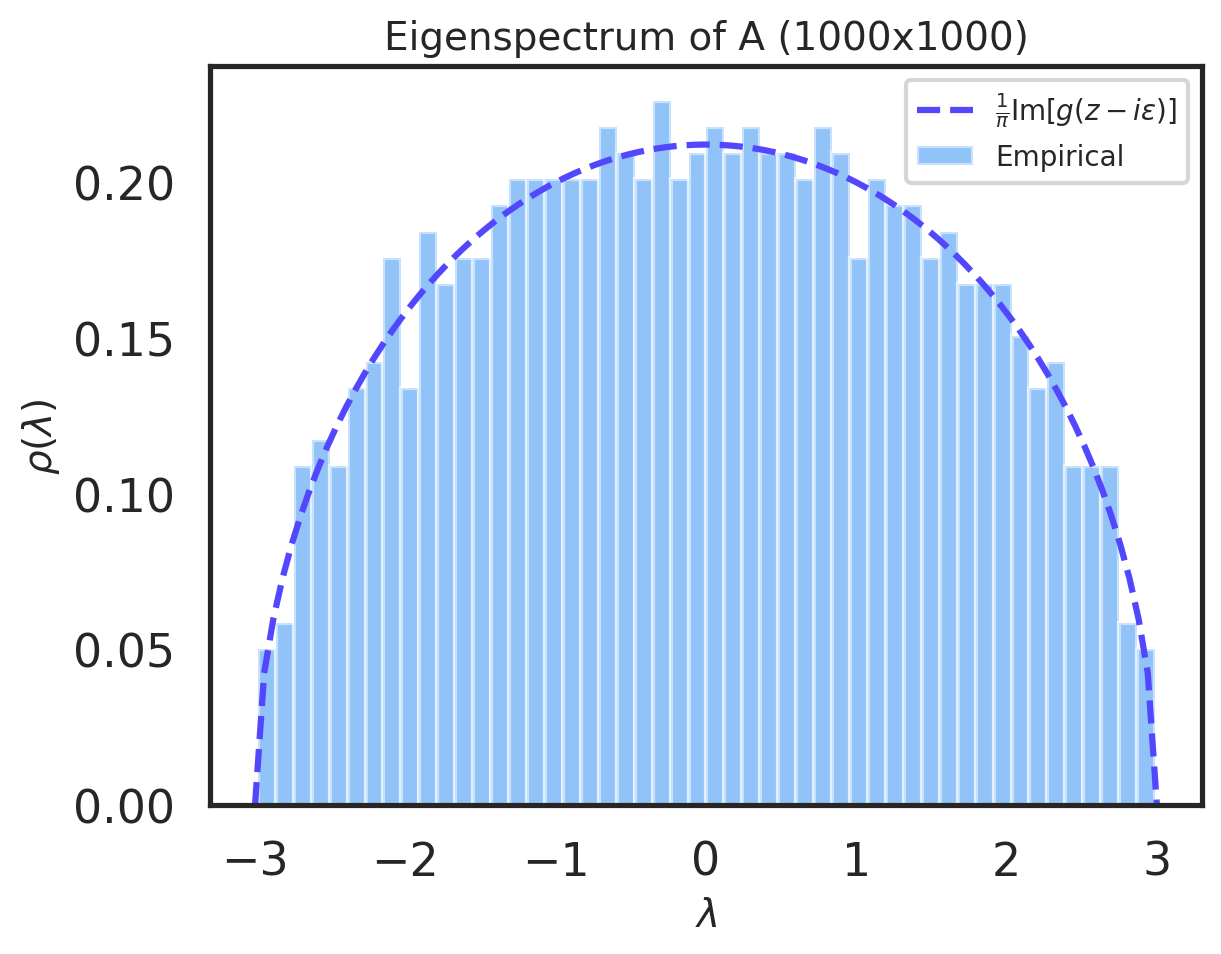

In [9]:
N = 1000
sigma = 1.5
# Generate a random Gaussian matrix
H = sigma*np.random.randn(N, N) / np.sqrt(N)
A = (H + H.T)*1/np.sqrt(2)

# Compute the eigenvalues of A
evals, _ = np.linalg.eigh(A)


plt.figure()
plt.title(f'Eigenspectrum of A ({N}x{N})',fontsize=14)


# Plot the semicircle law
x = np.linspace(-2*sigma, 2*sigma, 100)
y = np.sqrt(4*sigma**2 - x**2) / (2* np.pi * sigma**2)
plt.plot(x, y, label='$\\frac{1}{\\pi} \\mathrm{Im}[g(z - i \\epsilon)]$', ls='--')

# Plot the eigenspectrum
plt.hist(evals, bins=50, density=True, alpha=0.5, label=f'Empirical')


plt.xlabel('$\\lambda$',fontsize=14)
plt.ylabel('$\\rho(\\lambda)$', fontsize=14)
plt.legend(fontsize=10)
plt.show()


This case will be less interesting to us than the Wishart case

## Wishart

We begin first with the white wishart matrix $W = H^T H / P$ where $H$ is a $P \times N$ matrix of random entries  $H_{\mu j} \sim N(0, 1)$. $H$ should be interpreted in statistics as a *design matrix*, where each row is a datapoint and each column is a feature.

Define $q = N/P$ as the *overparameterization ratio*. Lets generate

In [11]:
N = 500

all_evals = []
for i, q in enumerate(np.logspace(-1, 1, 5)):
    P = int(N/q)

    # Generate Gaussian data for N > P
    data = np.random.normal(0, 1, (N, P))

    # Compute the empirical covariance matrix and its eigenvalues
    cov_matrix = np.cov(data)
    eigenvalues = np.linalg.eigvalsh(cov_matrix)

    all_evals += [eigenvalues]


<ipython-input-12-71c75a89f3da>:2: RuntimeWarning: invalid value encountered in divide
  return np.sqrt((lambda_plus - l) * (l - lambda_minus)) / (2 * np.pi * q * l)


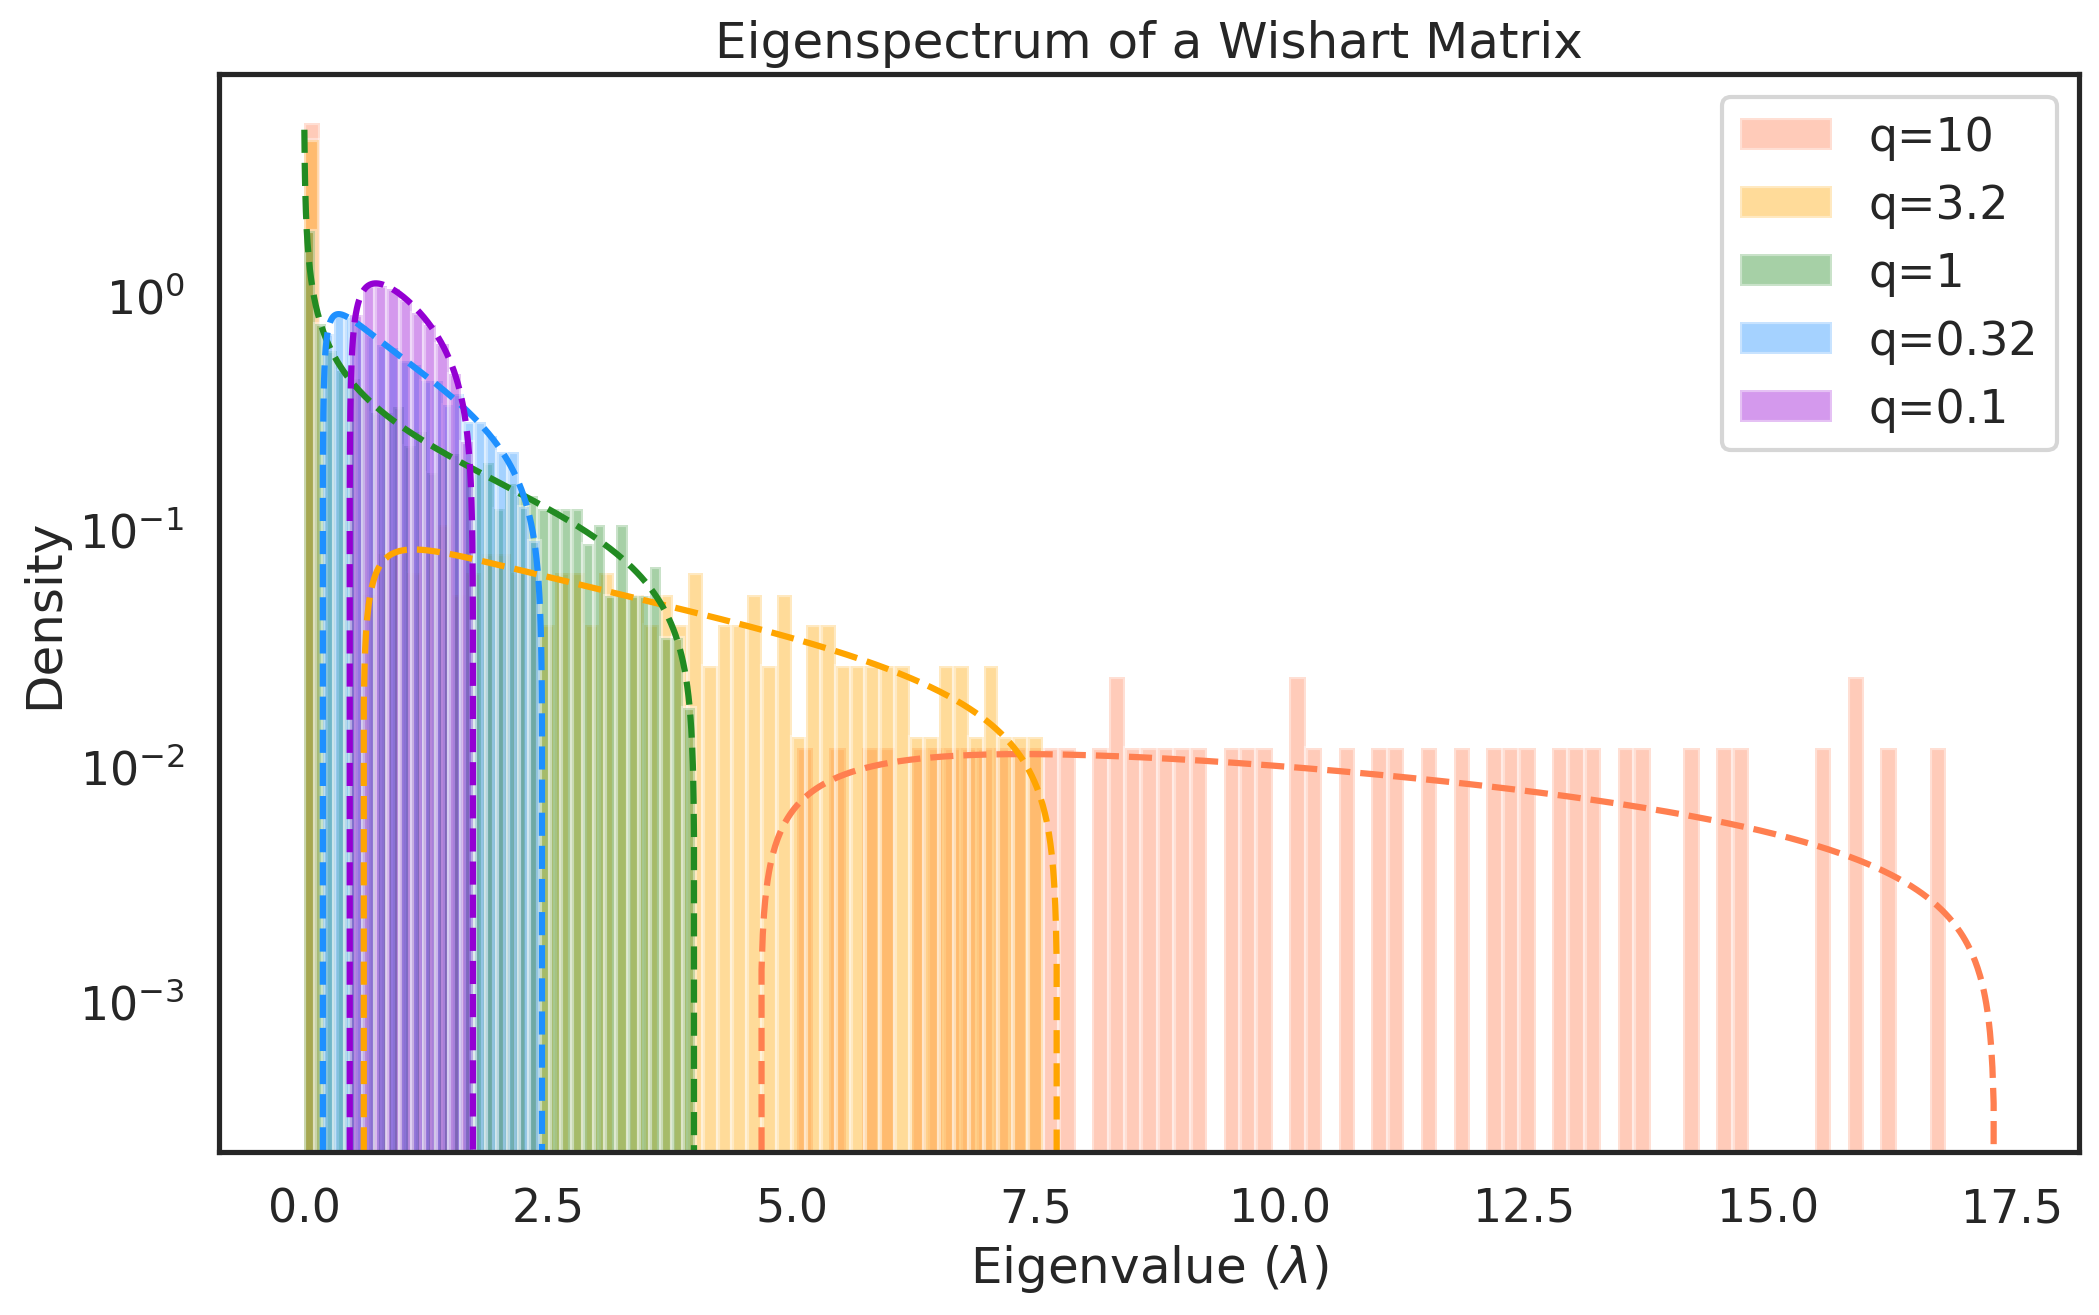

In [12]:
def theoretical_spectrum(l):
    return np.sqrt((lambda_plus - l) * (l - lambda_minus)) / (2 * np.pi * q * l)

plt.figure(figsize=(12, 7))
bins = [10, 20, 35, 50, 100]

colors = ['darkviolet', 'dodgerblue', 'forestgreen', 'orange', 'coral']

qs = np.logspace(-1, 1, 5)

for i in reversed(range(5)):
    q = qs[i]
    eigenvalues = all_evals[i]
    # Theoretical spectrum bounds and function for q > 1
    lambda_plus = (1 + np.sqrt(q))**2
    lambda_minus = (1 - np.sqrt(q))**2


    # Plotting the empirical histogram
    # Use a range to better focus on the continuous part of the spectrum
    plt.hist(eigenvalues, bins=bins[i], density=True, alpha=0.4, color=colors[i], label=f'q={q:.2g}')

    # Adding the theoretical curve
    linspace = np.linspace(lambda_minus, lambda_plus, 1000)
    plt.plot(linspace, theoretical_spectrum(linspace), c=colors[i], ls='--')

    # Highlighting the delta function at 0
    delta_weight = 1 - 1/q

plt.xlabel('Eigenvalue ($\lambda$)')
plt.ylabel('Density')
plt.yscale('log')
plt.title('Eigenspectrum of a Wishart Matrix')
plt.legend()
plt.savefig('figures/white_wishart.pdf', bbox_inches='tight')

## Structured Wishart

We now consider the setting where the data has power law structure, with the kth principal component having eigenvalue $k^{-\alpha}$. $\alpha$ is known as the *capacity exponent* and is one of the two most important exponents in determining neural scaling laws.

In [24]:
N = 1000
alpha = 1.2
qs = np.logspace(-1, 1, 5)
all_evals = []
population_spectrum = np.array([k**(-alpha) for k in range(1, N+1)])
S = np.diag(population_spectrum)
for i, q in enumerate(np.logspace(-1, 1, 5)):
    P = int(N/q)

    # Generate Gaussian data for N > P
    X = np.random.normal(0, 1, (P, N)) @ S**(0.5)

    # Compute the empirical covariance matrix and its eigenvalues
    cov_matrix = X.T @ X/P
    eigenvalues = sorted(np.linalg.eigvalsh(cov_matrix))[::-1]

    all_evals += [eigenvalues]


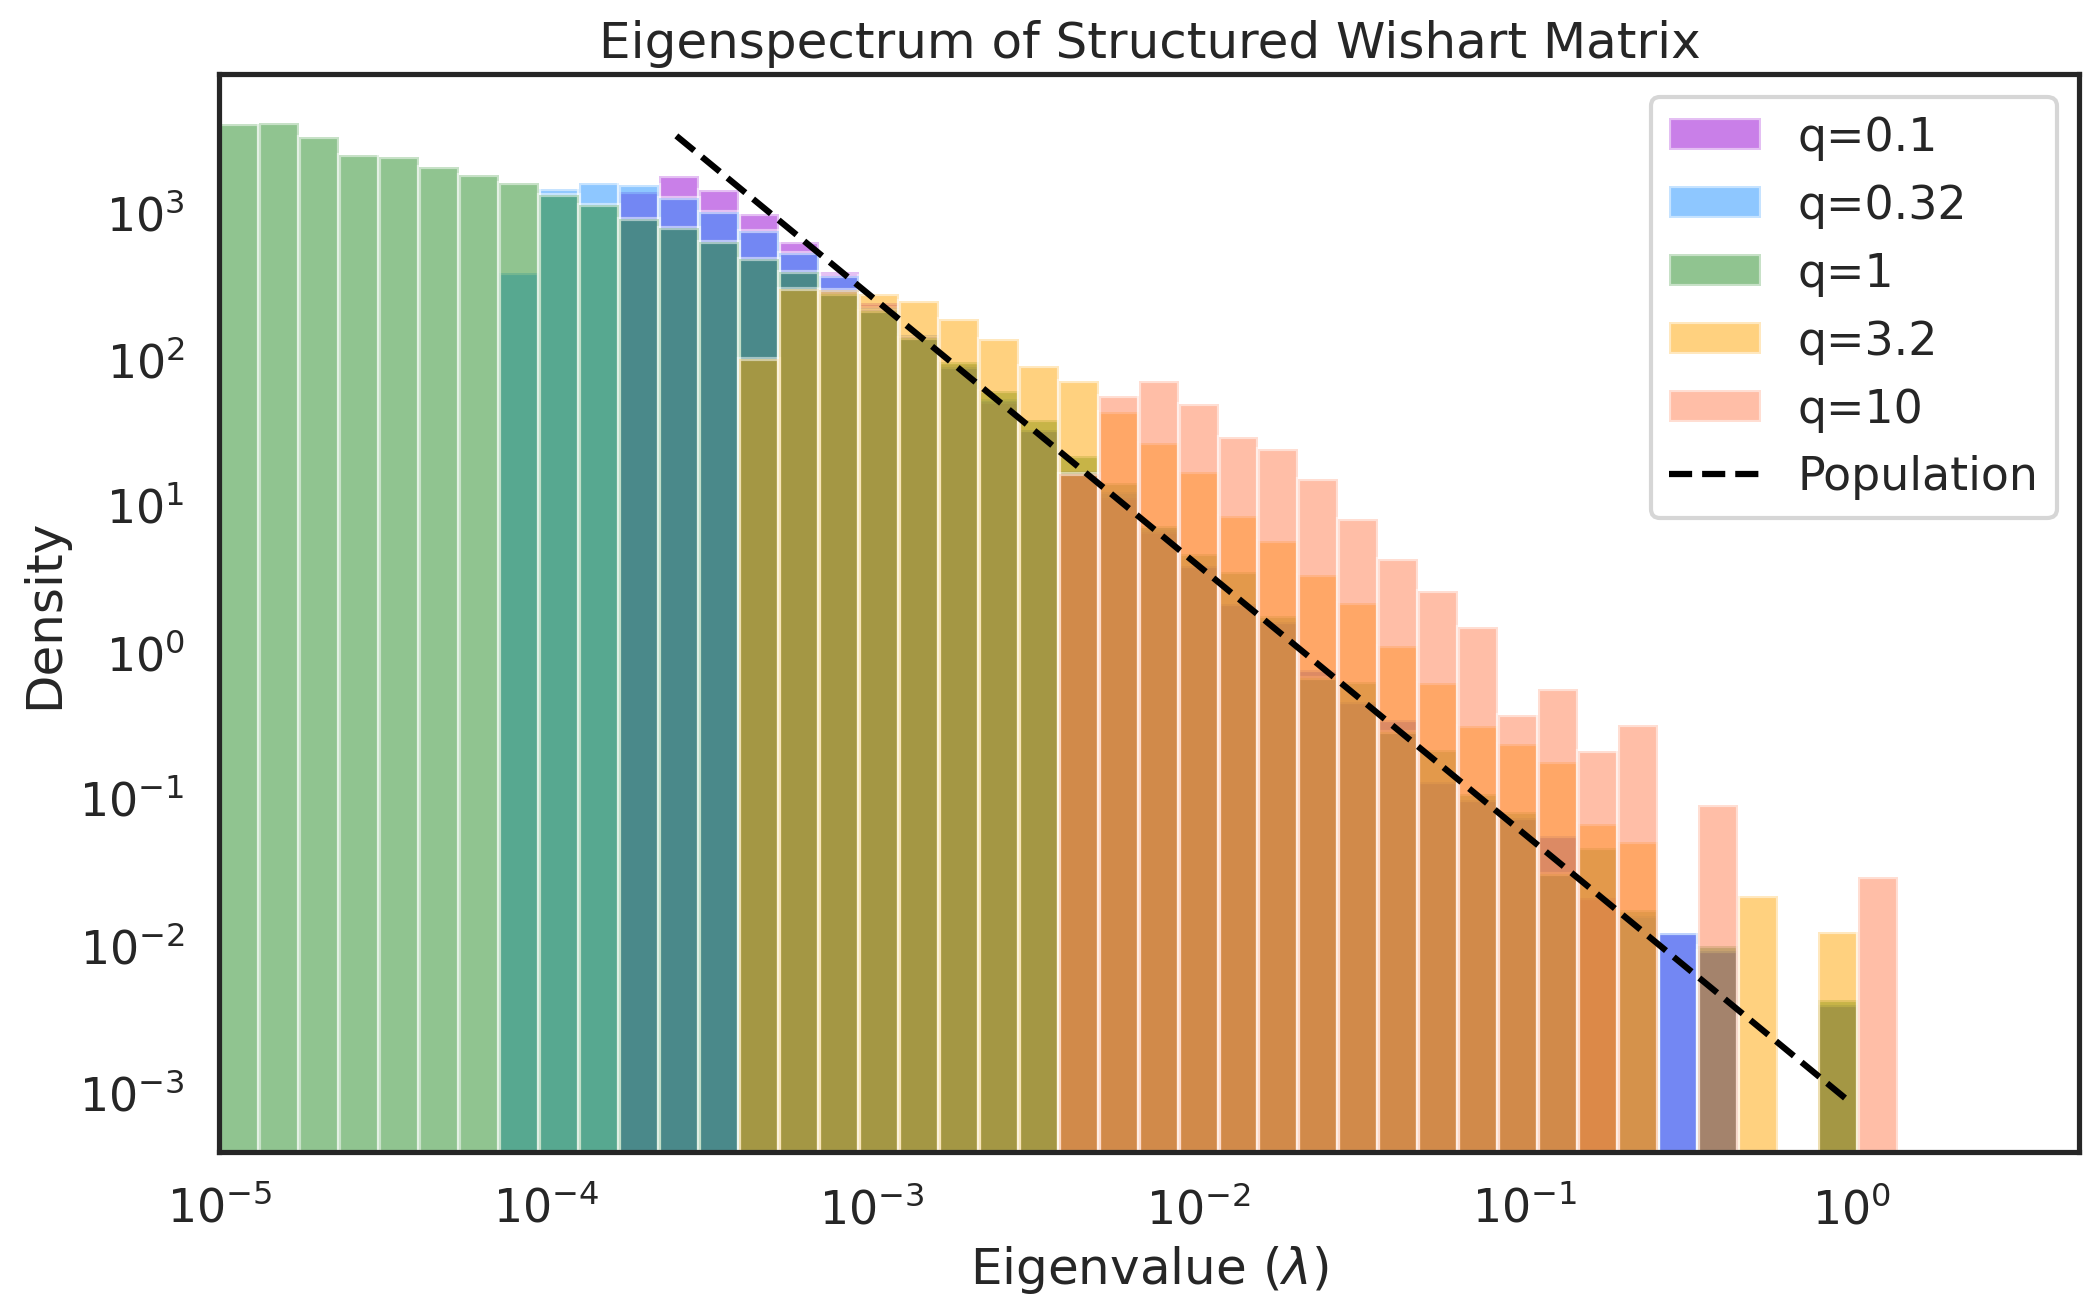

In [25]:
plt.figure(figsize=(12, 7))
sns.set_palette('rainbow', n_colors=10)
bins = [30, 30, 35, 50, 100]
qs = np.logspace(-1, 1, 5)
for i in (range(5)):
    q = qs[i]
    eigenvalues = all_evals[i]
    # Theoretical spectrum bounds and function for q > 1
    lambda_plus = (1 + np.sqrt(q))**2
    lambda_minus = (1 - np.sqrt(q))**2

    # Plotting the empirical histogram
    # Use a range to better focus on the continuous part of the spectrum
    plt.hist(eigenvalues, bins=np.logspace(-5, 1, 50), density=True, alpha=0.5, color=colors[i], label=f'q={q:.2g}')

plt.plot(np.logspace(np.log10(N**(-alpha)), 0, 1000), 1/(alpha * (N-1)) * np.logspace(np.log10(N**(-alpha)), 0, 1000)**(-1-1/alpha), 'k--', label='Population')
plt.xlabel('Eigenvalue ($\lambda$)')
plt.ylabel('Density')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-5, 5e0)
plt.title('Eigenspectrum of Structured Wishart Matrix')
plt.legend()
plt.savefig('figures/colored_wishart.pdf', bbox_inches='tight')


Play around with this and plot individual $q$ values. As $ q \to 0$, ie as $P \to \infty$ you resolve more and more of the spectrum.

## Degrees of Freedom and Deterministic Equivalence

We define the *degrees of freedom* $$df_{M}^1(\lambda) \equiv \frac{1}{N} \mathrm{Tr}[M (M + \lambda)^{-1}].$$
The degrees of freedom are the key measure that enters in the generalization error formulas that measures *how much of the spectrum has been resolved*. We can also write this in terms of the spectrum $\eta_i$ of $M$ as:

$$df_1(\lambda) \equiv \frac{1}{N} \sum_{i} \frac{\eta_i}{\eta_i+ \lambda}.$$

Text(0, 0.5, '$df_1(\\lambda)$')

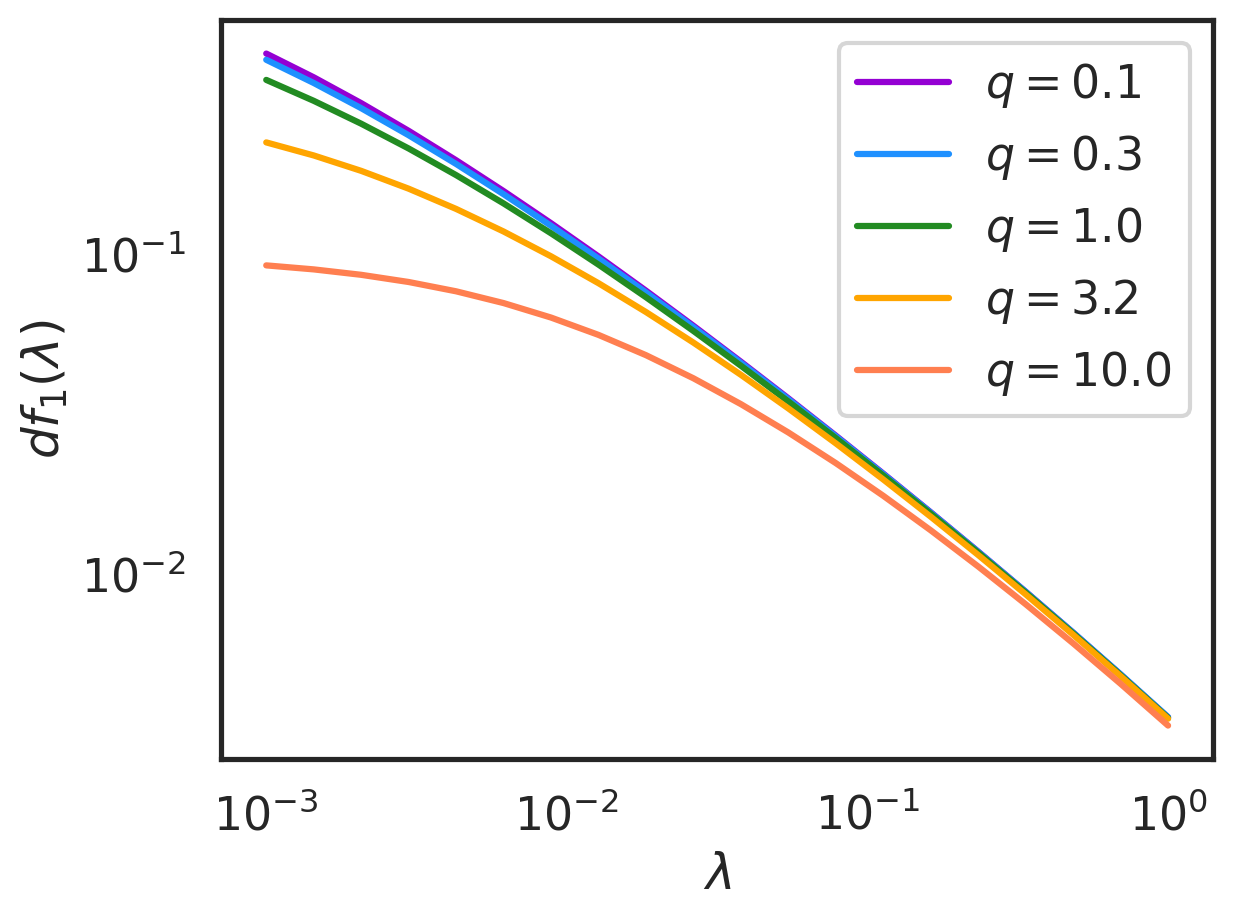

In [38]:
def df_1(etas, lamb):
  return jnp.mean(etas/(lamb+etas))


lambs = jnp.logspace(-3, 0, 20)
for i, (q, evals) in enumerate(zip(qs, all_evals)):
    dfs = vmap(df_1, in_axes=(None, 0))(jnp.array(evals), lambs)
    plt.plot(lambs, dfs, label=f"$q=${q:.1f}",  color=colors[i])

plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('$\lambda$')
plt.ylabel('$df_1(\lambda)$')


The central idea of deterministic equivalence is that:

$$ df^1_{\hat{ \, \Sigma}}(\lambda) = df^1_{\Sigma}(\kappa)$$

where $\kappa = \lambda S(df)$ is a renormalized ridge, also known as the *resolution*.  $S$ is a function of df known as the $S$-transform of the noise structure (in this case a white wishart). It can be estimated from the data alone!

In other words: The degrees of freedom of a finite $P$ covariance matrix $\hat {\, \Sigma}$ at a given ridge $\lambda$ is the same as the degrees of a freedom of the infinite $P$ covariance $\Sigma$

Let's do a precision test of this!

Text(0.5, 1.0, 'Deterministic Equivalence')

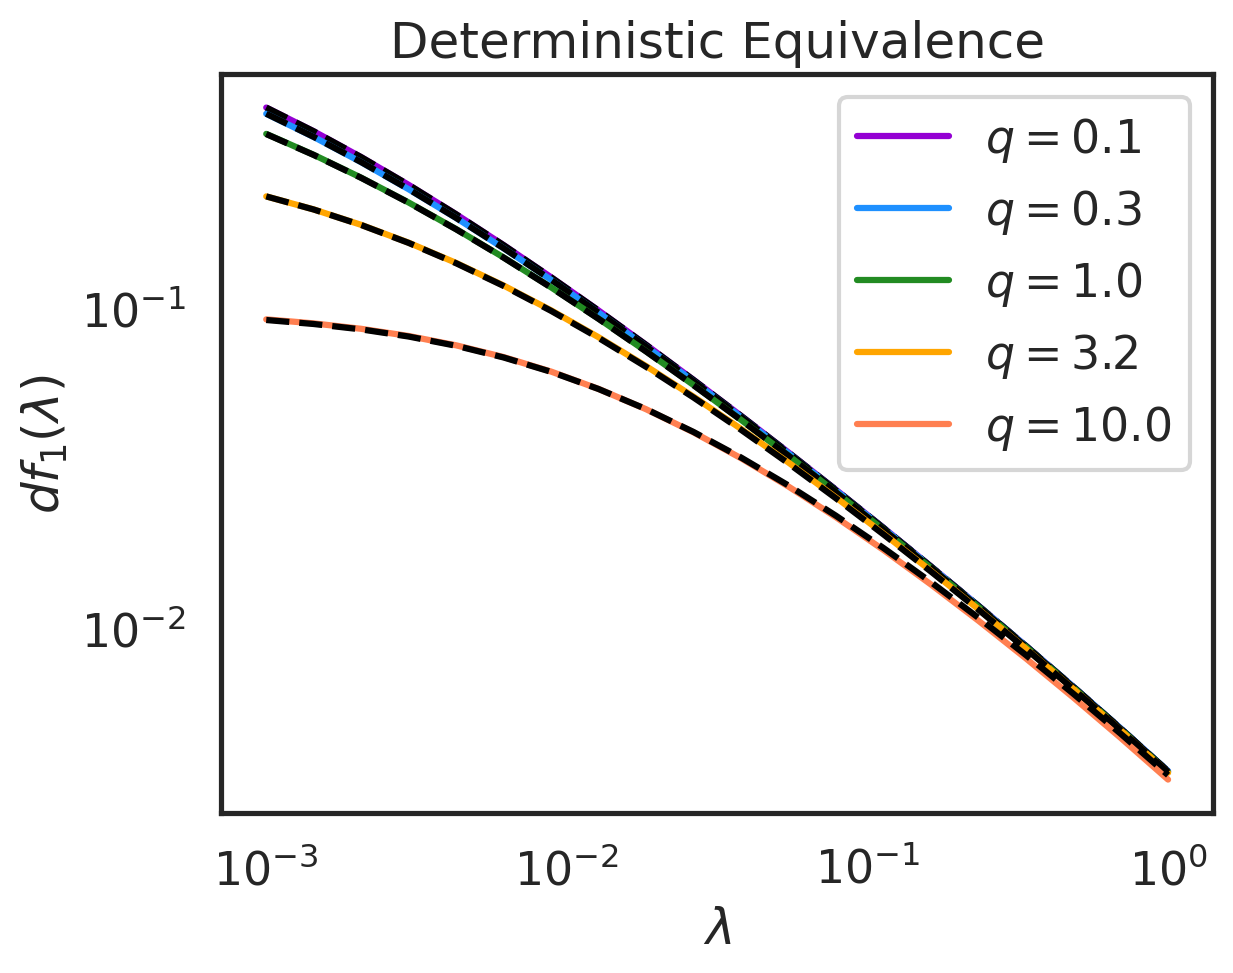

In [40]:
for i, (q, evals) in enumerate(zip(qs, all_evals)):
    dfs = vmap(df_1, in_axes=(None, 0))(jnp.array(evals), lambs)
    plt.plot(lambs, dfs, label=f"$q=${q:.1f}",  color=colors[i])
    # Estimate kappa as $\lambda * S$
    kappas = lambs/(1-q*dfs)
    dfs = vmap(df_1, in_axes=(None, 0))(population_spectrum, kappas)
    plt.plot(lambs, dfs, ls='--', c='k')

plt.yscale('log')
plt.legend()
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('$df_1(\lambda)$')
plt.title("Deterministic Equivalence")